In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
patient_gene_proj_scores = pd.read_table("../data/interim/patient_gene_proj_scores.csv", sep=",")
patient_gene_proj_scores.set_index("Sample ID", inplace=True)

In [39]:
patient_gene_proj_scores

,BANK1,BIK,BLK,BTNL2,CDHR5,CEP70,CHD7,CNTNAP2,DAP,DAPK1,...,TNFAIP3,TNFRSF13B,TNFSF4,TNIP1,TNPO3,TSPO,TTLL12,TYK2,UBE2L3,XKR6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Betty_Ill_4901_2,0.809474,0.479510,0.743162,0.970505,0.060524,0.068643,0.404527,0.573658,0.785266,1.221183,...,0.112997,0.235669,0.538472,0.272223,0.604225,0.640360,1.017127,0.449058,0.526472,1.628768
ucl223ILL1,1.223338,0.105189,0.925351,1.719975,0.109509,0.313414,1.739810,0.325379,1.933328,3.008968,...,0.352428,0.210859,0.350547,0.511407,0.613192,0.102948,0.303651,0.180382,0.541667,1.761100
Betty_Ill_3822_2,0.719220,0.162243,0.818166,0.343822,0.040570,0.299656,0.327366,0.410006,0.854593,1.285327,...,0.087790,0.307093,0.371443,0.491633,0.557684,0.335739,0.953208,0.210236,0.442091,2.988263
Betty_Ill_5103_2,1.296147,0.073125,0.238694,0.494056,0.064558,0.096801,0.356770,0.470179,0.801289,1.236076,...,0.288416,0.327325,0.206206,0.569323,0.544394,0.345916,0.772304,0.258980,0.511670,1.140355
Betty_Ill_1045_2,1.029908,0.159404,0.788404,0.684585,0.078699,0.081308,0.318829,0.376723,1.008886,1.543668,...,0.388319,0.361804,0.468867,0.457276,0.564898,0.345185,0.814385,0.342020,0.663334,1.618242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,2.061822,0.451081,0.878921,1.070708,0.220643,0.355156,0.568773,0.906408,1.684776,2.027510,...,0.402172,0.411129,0.648711,0.826498,1.155834,0.401217,0.462875,1.220084,0.815404,2.693893
57739,1.983748,0.411565,0.833145,0.571685,0.057062,0.448527,0.671546,0.880180,1.368353,2.109798,...,0.415054,0.988594,1.034811,0.347300,1.250365,0.364095,0.639646,0.555541,1.045926,1.869671
1561,1.052550,0.482508,0.541377,0.729623,0.092662,0.209166,0.501401,0.627381,1.384427,2.081192,...,0.091457,1.053527,0.516954,0.574756,1.585443,0.395316,0.884703,0.583642,1.766174,1.664315


In [7]:
pca_projs_concat_df = pd.read_table("../data/interim/PCA_projections_80_variance_SLE_samples.csv", sep=",", 
                                    index_col="Sample ID")

In [108]:
sample_cluster = pd.read_table("../data/interim/kmeans_patient_cluster5.csv", sep="," )
sample_cluster.set_index("patient_id", inplace=True)
sample_cluster["cluster"].value_counts()

3    221
5    158
4     92
1     88
2     75
Name: cluster, dtype: int64

# Predict Cluster from Gene Scores with Logistic Regression

In [223]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [229]:
np.arange(0,1,0.2)

array([0. , 0.2, 0.4, 0.6, 0.8])

In [239]:
lr = LogisticRegressionCV(Cs=10, cv=5, penalty="l1", 
                          l1_ratios=np.arange(0, 1, 0.2),
                        solver="saga",
                        multi_class="ovr", n_jobs=4)
print(lr.fit(patient_gene_proj_scores, sample_cluster["cluster"]))

/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1992: UserWarning: l1_ratios parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  self.penalty))
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=array([0. , 0.2, 0.4, 0.6, 0.8]), max_iter=100,
                     multi_class='ovr', n_jobs=4, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol=0.0001, verbose=0)
0.889589905362776


/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [238]:
lr.score(patient_gene_proj_scores, sample_cluster["cluster"])

0.889589905362776

In [240]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

scores = cross_val_score(lr, patient_gene_proj_scores, sample_cluster["cluster"], cv=5, 
                         scoring="f1_micro")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1992: UserWarning: l1_ratios parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  self.penalty))
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1992: UserWarning: l1_ratios parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  self.penalty))
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1992: UserWarning: l1_ratios parameter is only used when penalty is 'elastic

KeyboardInterrupt: 

# gene variability score with Logistic Regression

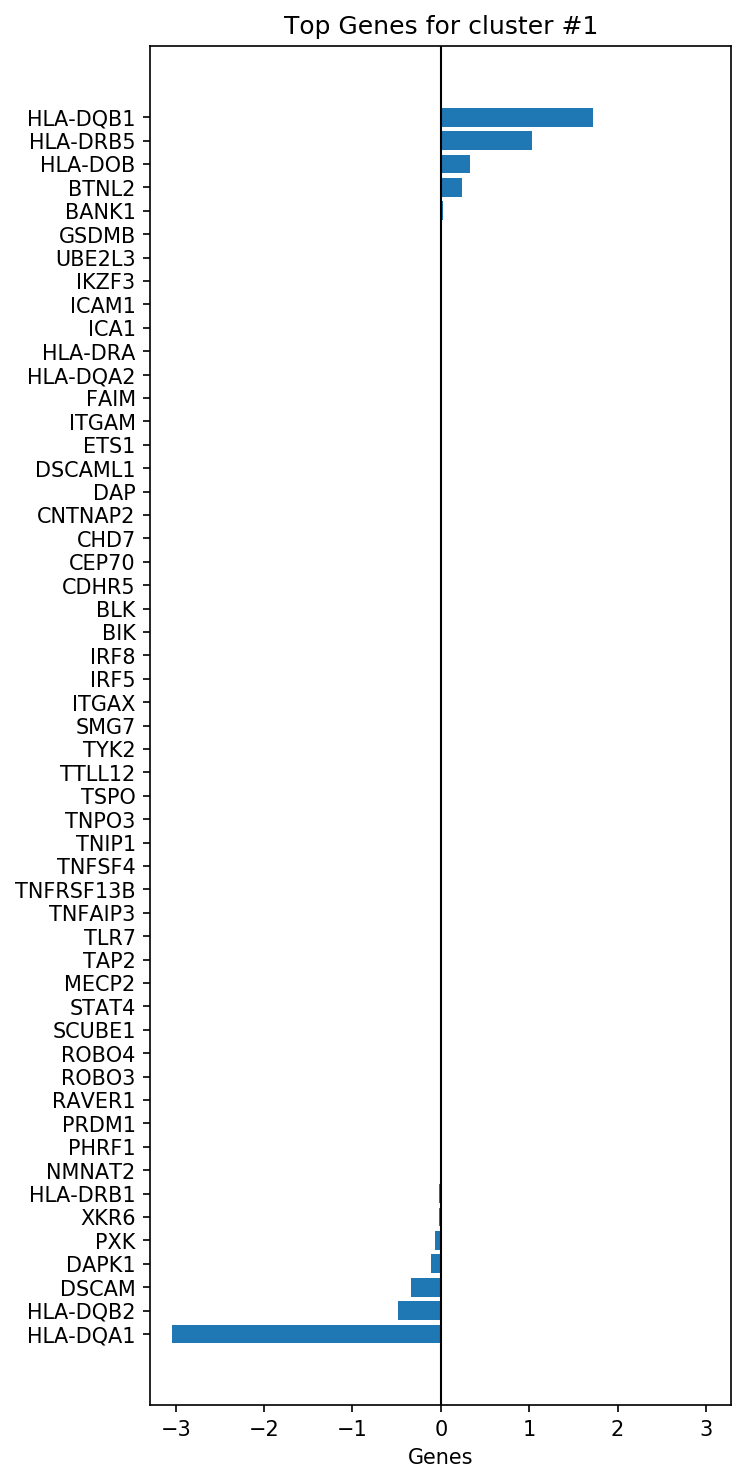

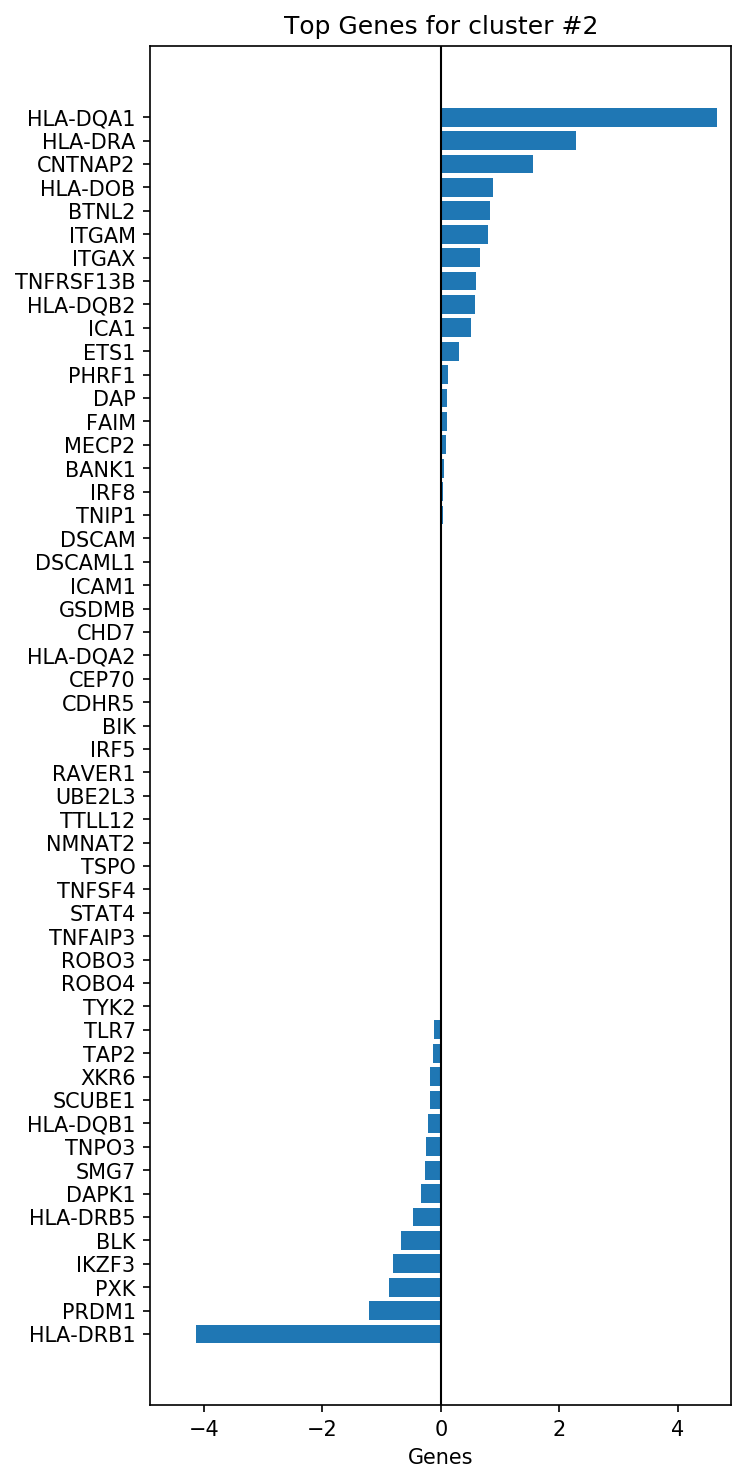

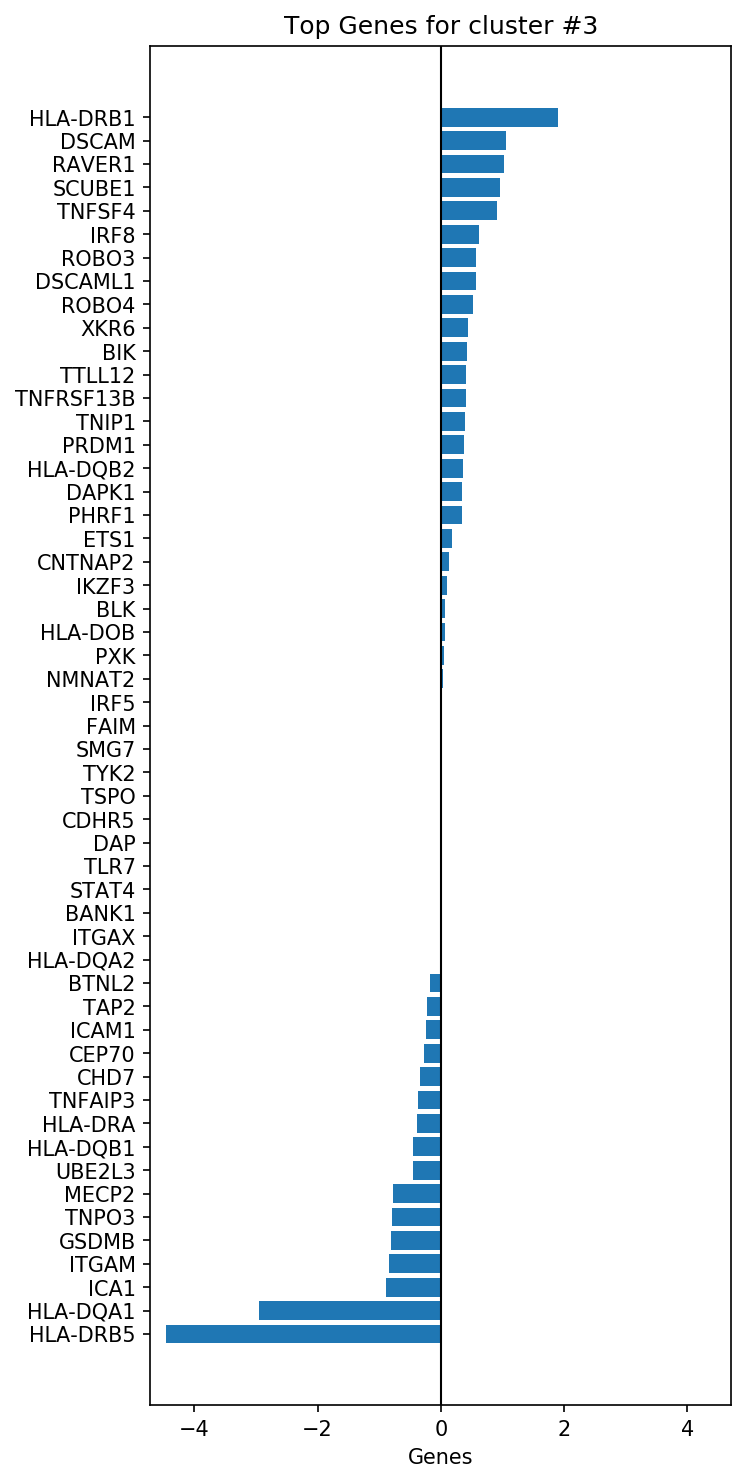

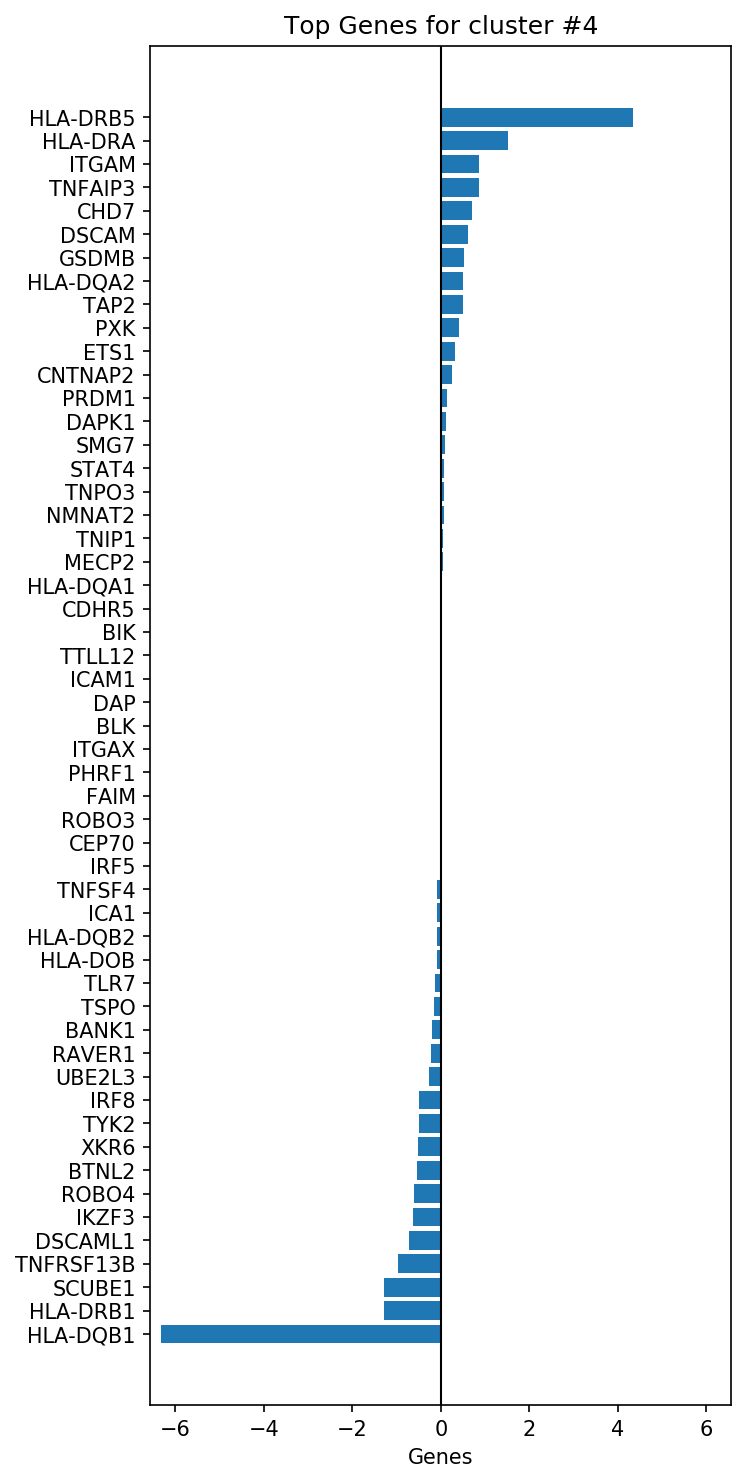

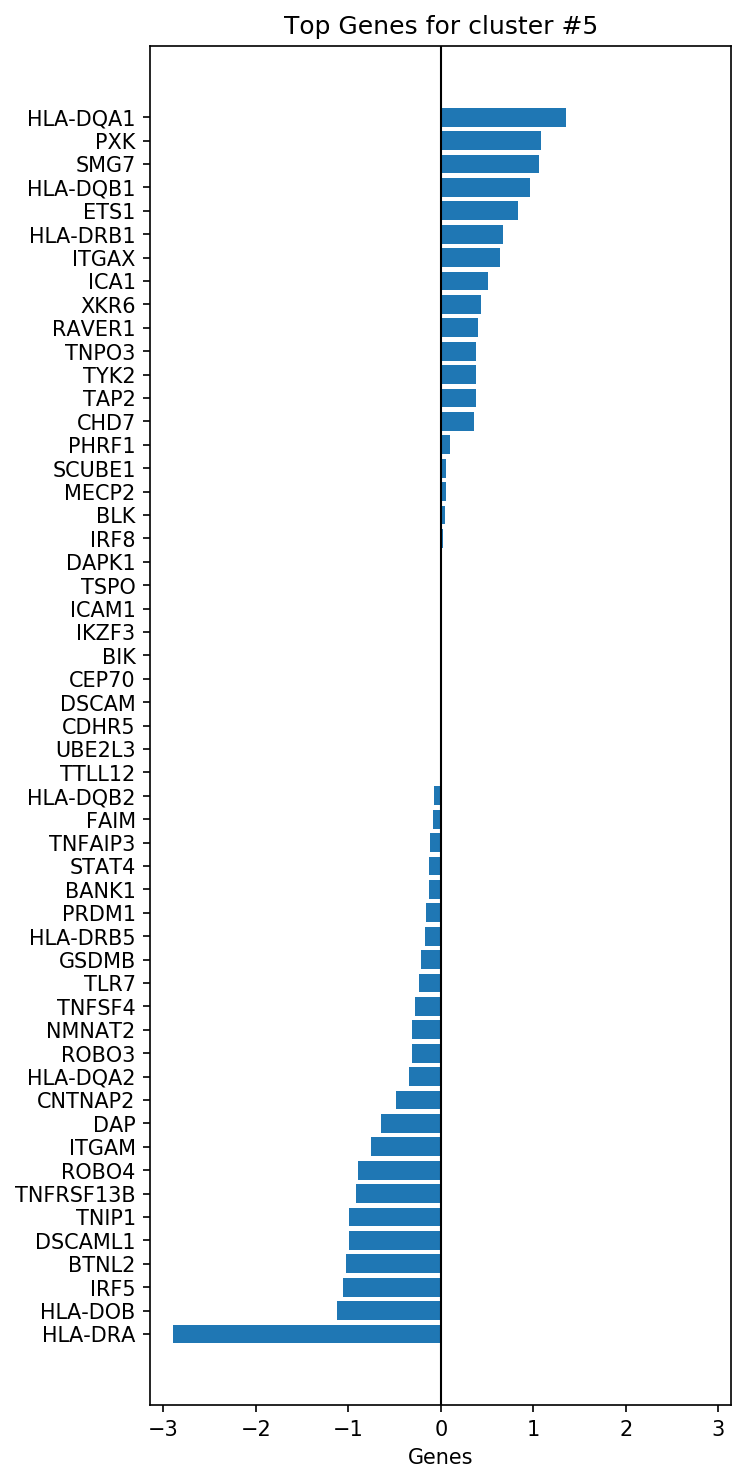

In [241]:
for cluster in range(lr.coef_.shape[0]):
    fig = plt.figure(figsize=(5, 12), dpi=150)
    genes_ordered = np.argsort(lr.coef_[cluster])
    ax = fig.add_subplot(111)
    ax.set_title("Top Genes for cluster #{}".format(cluster+1))
    ax.set_xlabel("Genes")
    ax.axvline(0, color='k',lw=1)   # poor man's zero level
#     ax.spines['bottom'].set_position('center')
#     plt.xticks(rotation=90)
    abs_max = max(np.abs(lr.coef_[cluster]))+0.25
    ax.set_xlim((-abs_max, abs_max))
    ax.barh(y=patient_gene_proj_scores.columns[genes_ordered], 
            width=lr.coef_[cluster][genes_ordered],
           align='center')
    

# Clustering centroids

In [120]:
gene_proj_scores_by_cluster = patient_gene_proj_scores.join(sample_cluster["cluster"])
gene_proj_scores_cluster_means = gene_proj_scores_by_cluster.groupby("cluster").agg("mean")
gene_center_mean = patient_gene_proj_scores.mean(axis=0)

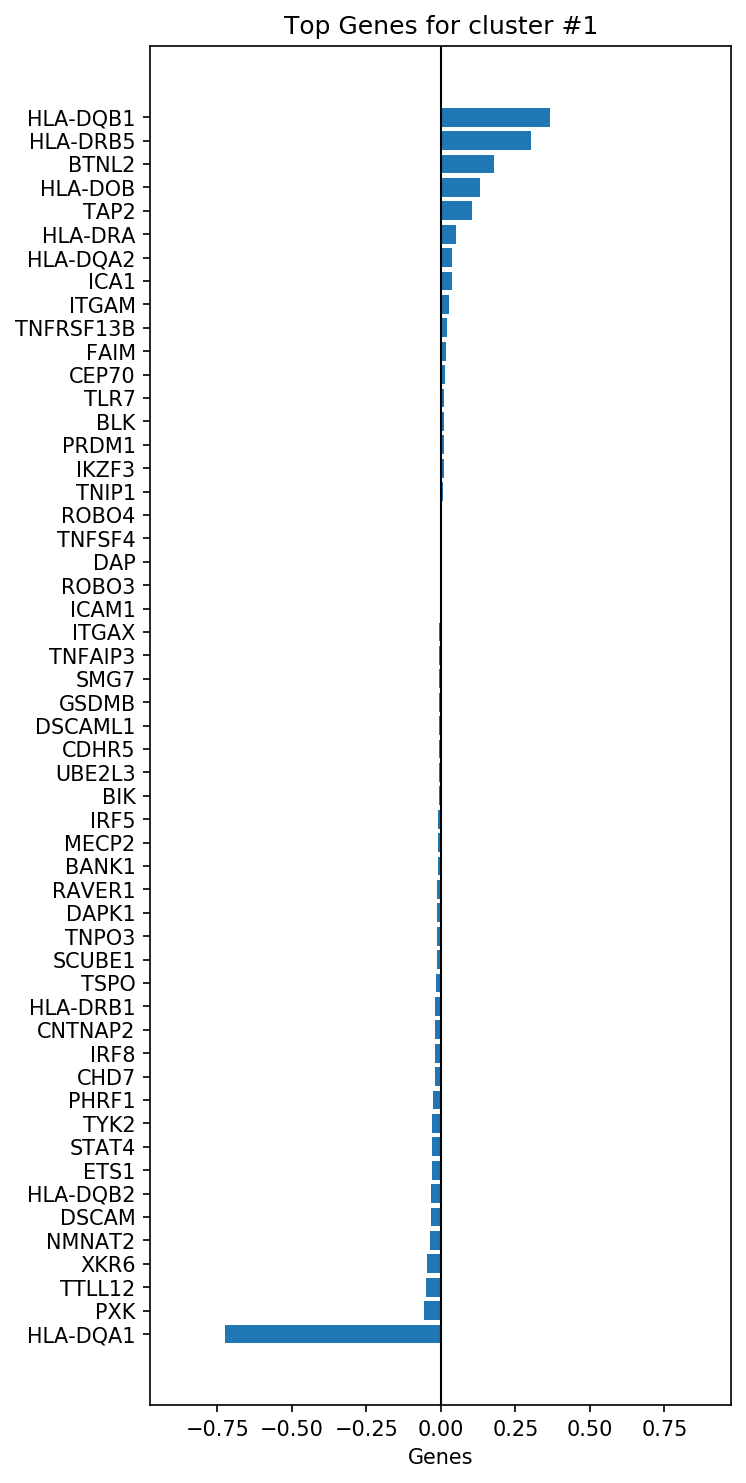

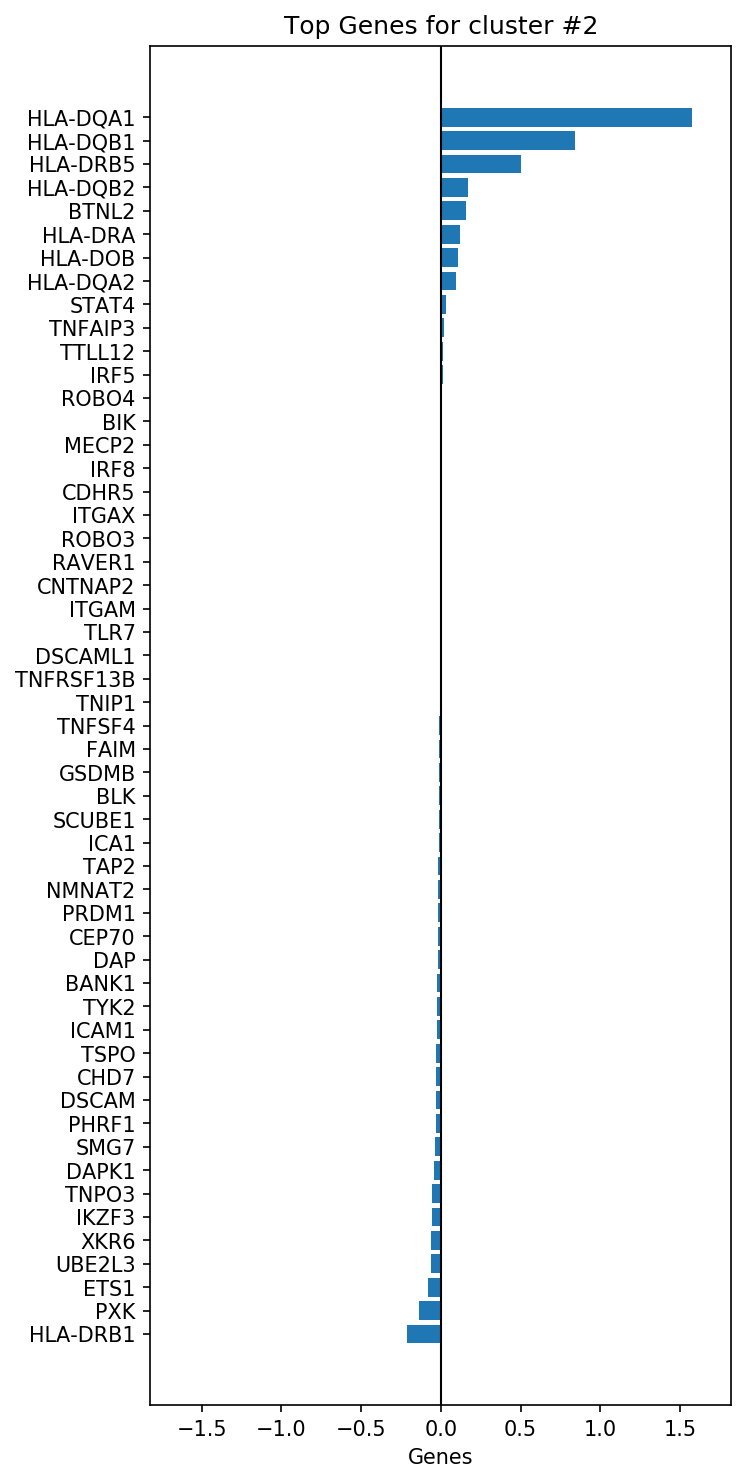

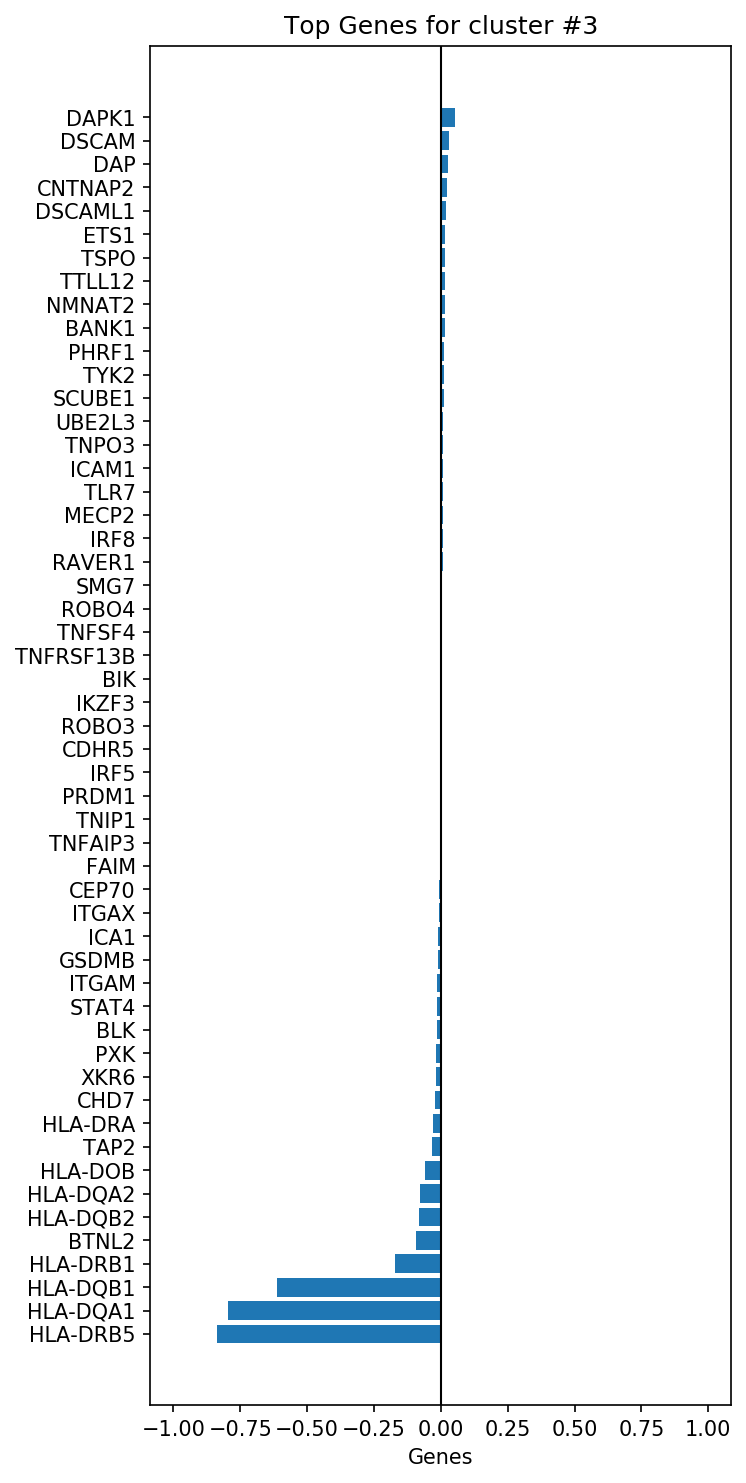

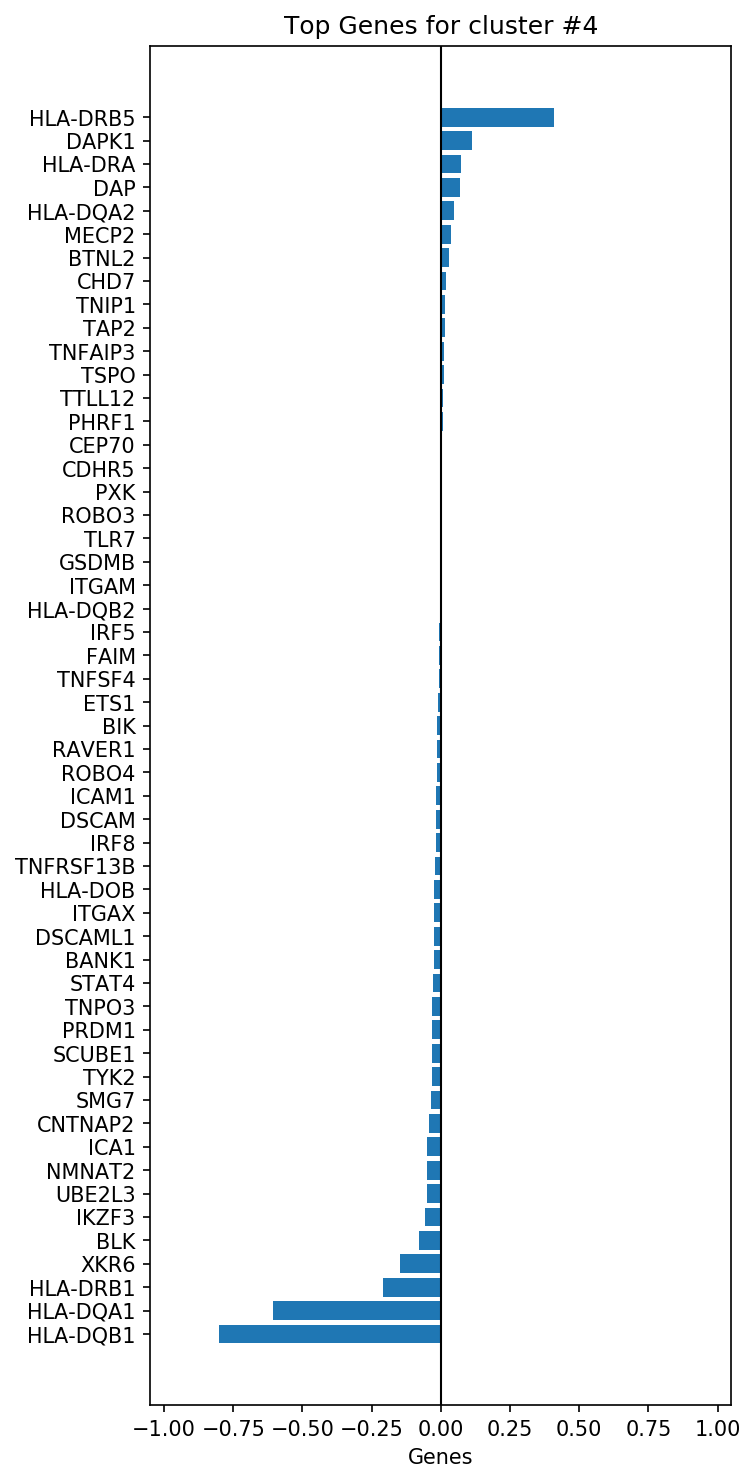

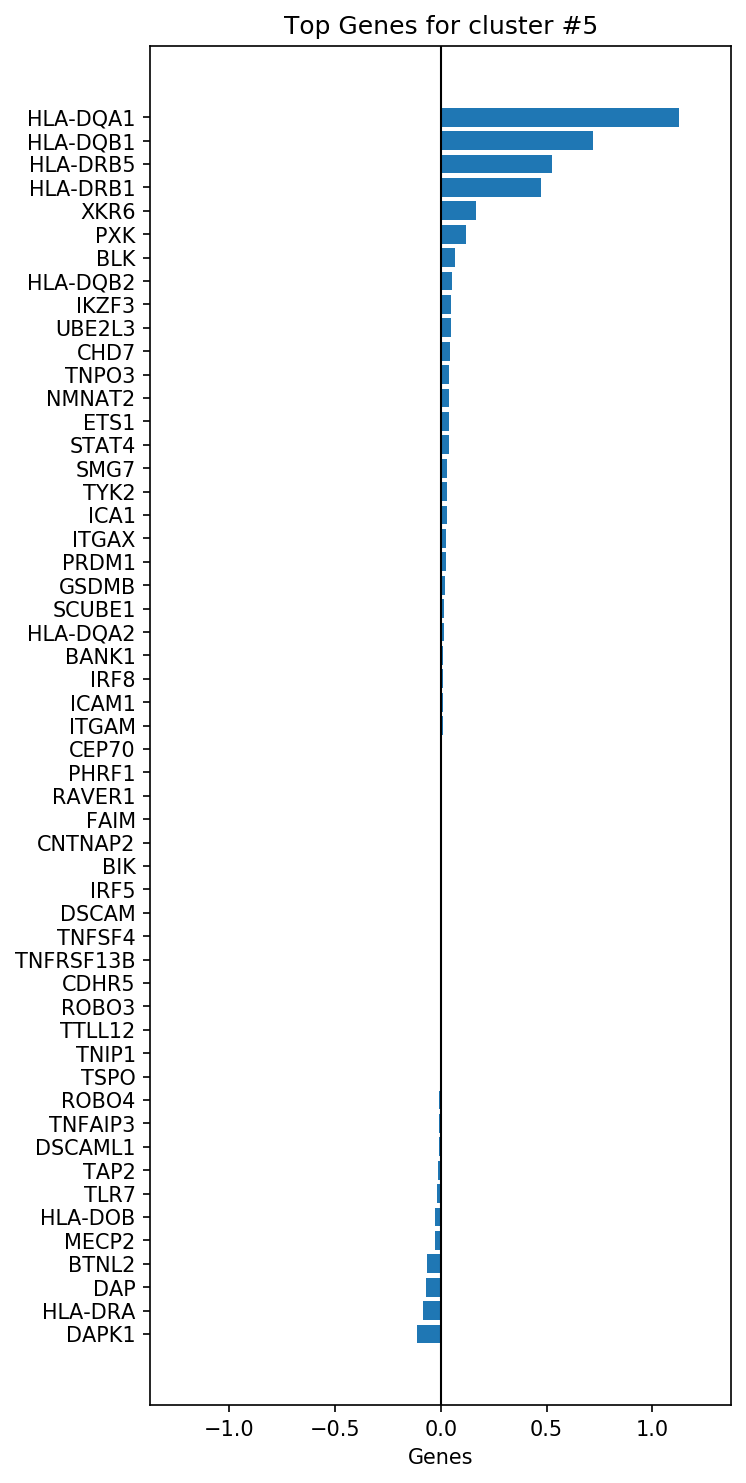

In [130]:
for cluster in range(gene_proj_scores_cluster_means.shape[0]):
    gene_score_diff = gene_proj_scores_cluster_means.iloc[cluster] - gene_center_mean
    fig = plt.figure(figsize=(5, 12), dpi=150)
    genes_ordered = np.argsort(gene_score_diff)
    ax = fig.add_subplot(111)
    ax.set_title("Top Genes for cluster #{}".format(cluster+1))
    ax.set_xlabel("Genes")
    ax.axvline(0, color='k',lw=1)   # poor man's zero level
    abs_max = max(np.abs(gene_score_diff))+0.25
    ax.set_xlim((-abs_max, abs_max))
    ax.barh(y=gene_score_diff.index[genes_ordered], 
            width=gene_score_diff[genes_ordered],
           align='center')

# Cosine similarity between genes by variability

In [203]:
gene_cov = patient_gene_proj_scores.cov()

In [211]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=7, n_neighbors=3)
gene_cluster = sc.fit_predict(gene_cov)
gene_cluster_sorted = np.argsort(gene_cluster)

/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/cluster/spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


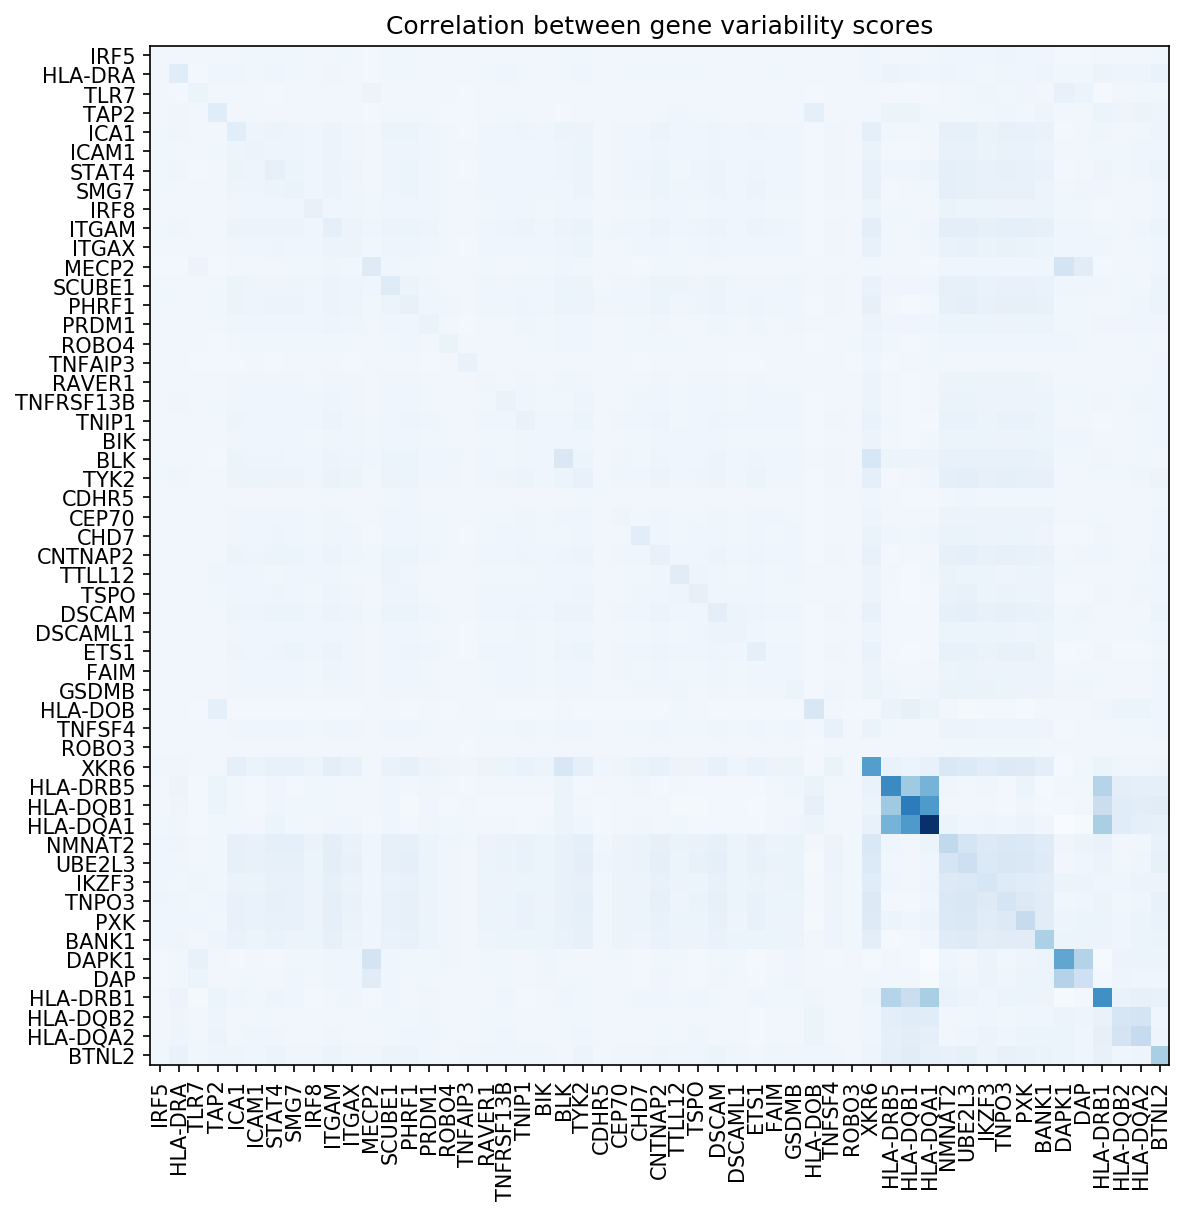

In [221]:
fig, ax = plt.subplots(figsize=(9,9), dpi=150)
genes_list = gene_cov.index[gene_cluster_sorted]
ax.set_title("Correlation between gene variability scores")
ax.set_xticks(np.arange(len(genes_list)))
ax.set_yticks(np.arange(len(genes_list)))
ax.set_xticklabels(genes_list, rotation=90)
ax.set_yticklabels(genes_list)
im = ax.imshow((gene_cov+0.6).iloc[gene_cluster_sorted.tolist(), gene_cluster_sorted.tolist()], cmap="Blues")